# Store Sales - Time Series Forecasting 전처리

In [1]:
import os
import sys
from datetime import datetime
from zipfile import ZipFile
from io import BytesIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import tensorflow as tf

2024-02-17 18:21:47.262242: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-17 18:21:47.589761: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 18:21:47.589806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 18:21:47.630944: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-17 18:21:47.715149: I tensorflow/core/platform/cpu_feature_guar

In [2]:
tf.config.list_physical_devices()

2024-02-17 18:21:50.076981: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-17 18:21:50.202412: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-17 18:21:50.202473: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2024-02-17 18:21:50.227335: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-17 18:21:50.227440: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-17 18:21:50.227470: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-17 18:21:50.510290: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-17 18:21:50.510368: I external/local_xla/xla/stream_executor

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6711740081394012918
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10013900800
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15934510152732757628
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

## Set envs

In [4]:
PATH_INPUT = '/mnt/d/proj/Machine Learning/datas/'
PATH_OUTPUT = './data/out/'
NOW_STR = datetime.now().strftime('%Y%m%d_%H%M%S')
PATH_OUTPUT_NOW = f'./data/out/{NOW_STR}/'

try:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    gpus = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)]
    )
except:
    print("NO GPU")

## Check Data

### Get Data

In [5]:
df = {}
with ZipFile(PATH_INPUT + 'store-sales-time-series-forecasting.zip') as f:
    for fnmae in f.namelist():
        # varname = fnmae.replace(".csv", "")
        # print(varname)
        # globals()[f'df_{varname}'] = pd.read_csv(BytesIO(f.read(fnmae)))

        print(fnmae)
        df[fnmae.replace(".csv", "")] = pd.read_csv(BytesIO(f.read(fnmae)))

holidays_events.csv
oil.csv
sample_submission.csv
stores.csv
test.csv
train.csv
transactions.csv


In [6]:
df_keys = [ 'holidays_events', 'oil', 'stores', 'test', 'train', 'transactions' ]

### Print Data

In [7]:
df['train'].head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [8]:
df['test'].head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [9]:
df['stores'].head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [10]:
df['oil'].head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [11]:
df['holidays_events'].head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [12]:
df['transactions'].head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [13]:
df['sample_submission'].head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


## Data Visualization

### Data add column (year, month)

In [14]:
def _(v):
    splitter = v.split("-")
    if len(splitter) >= 2:
        return [splitter[0],splitter[1]]
    else:
        return [None, None]

for k in df_keys:
    if "date" in df[k].keys():
        # df[k]['year'] = df[k]['date'].split("-")[1]
        # df[k]['month'] = df[k]['date'].split("-")[2]
        print(k)
        df[k][['year','month','_']] = df[k]['date'].str.split("-", expand=True, n=2)
        df[k].drop(columns=['_'], inplace=True)

holidays_events
oil
test
train
transactions


In [15]:
df['train']

,id,date,store_nbr,family,sales,onpromotion,year,month
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,2013,01
1,1,2013-01-01,1,BABY CARE,0.000,0,2013,01
2,2,2013-01-01,1,BEAUTY,0.000,0,2013,01
3,3,2013-01-01,1,BEVERAGES,0.000,0,2013,01
4,4,2013-01-01,1,BOOKS,0.000,0,2013,01
...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,2017,08
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2017,08
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,2017,08
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2017,08


<AxesSubplot:xlabel='year', ylabel='sales'>

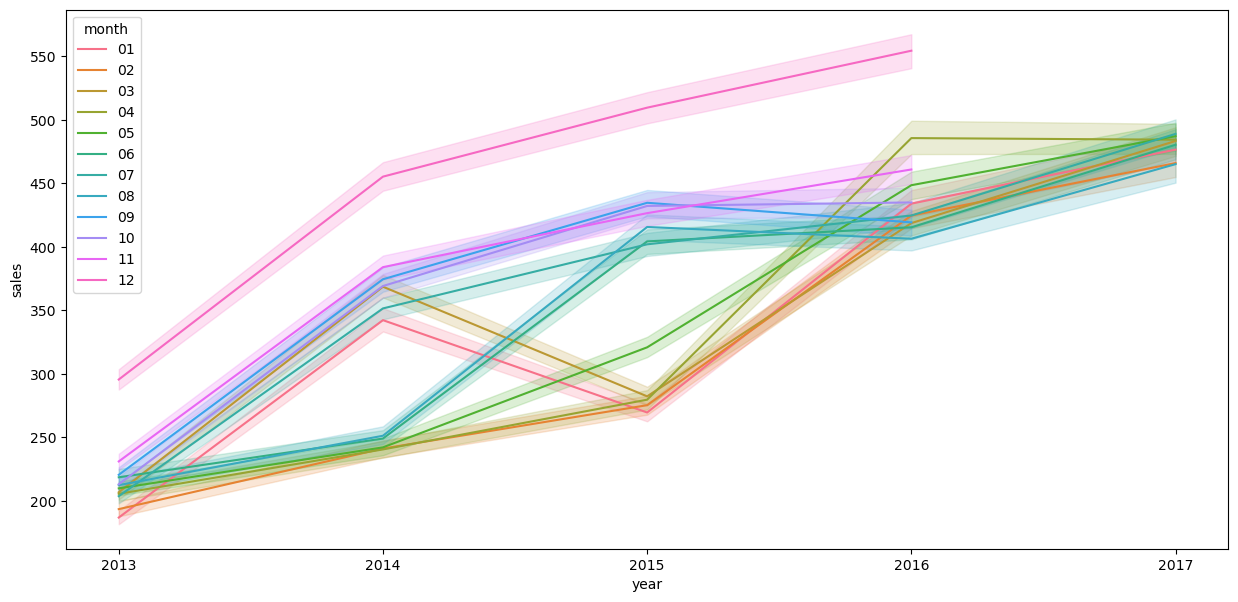

In [16]:
plt.figure(figsize=(15,7))
sns.lineplot(data=df['train'], x='year', y='sales', hue='month')

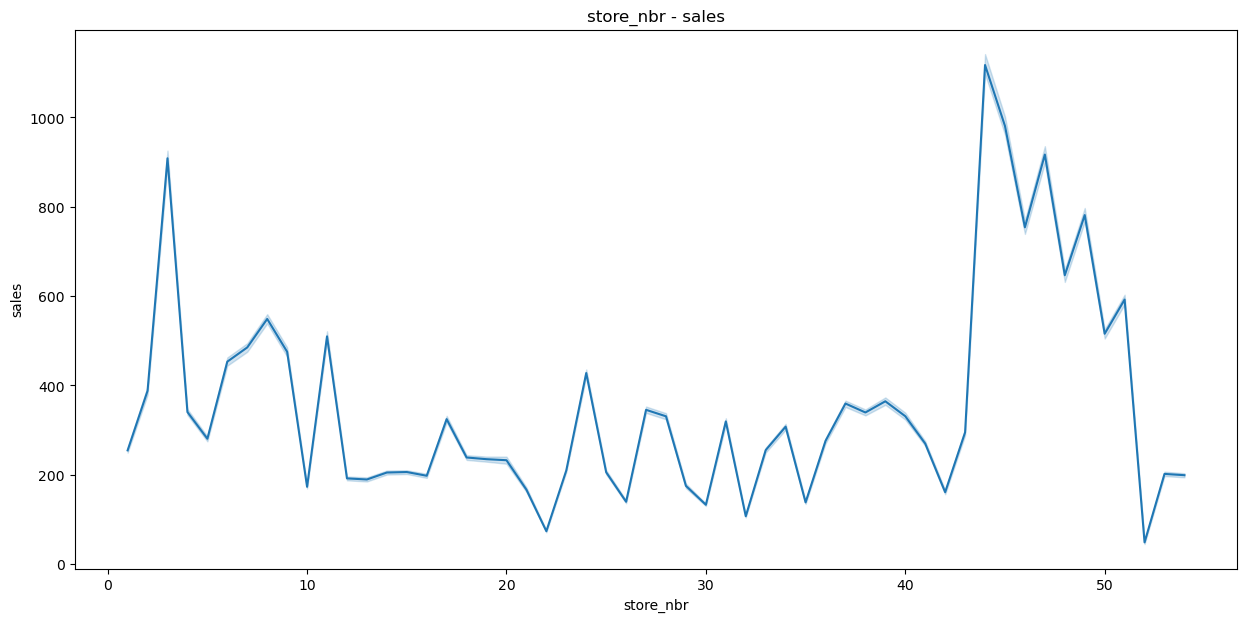

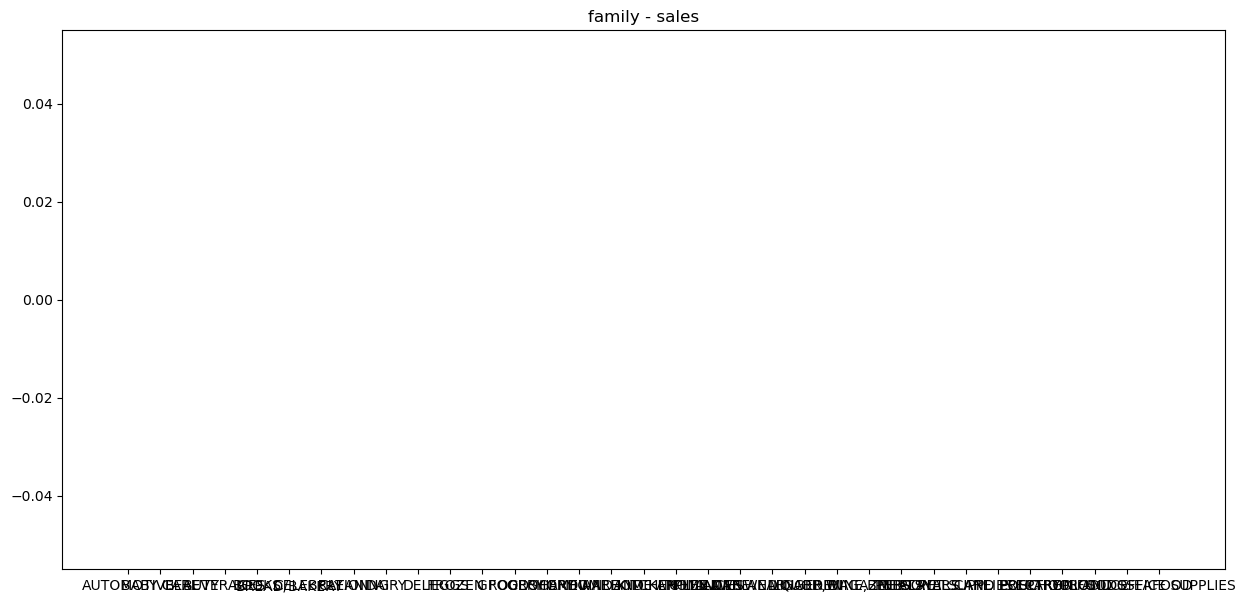

In [21]:
plt.figure(figsize=(15,7))
plt.title('store_nbr - sales')
sns.lineplot(data=df['train'], x="store_nbr", y="sales")
plt.show()
